In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.regression.linear_model import OLS

import matplotlib.colors as col
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
from pathlib import Path  
import random

# Scikit-Learn models:

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import catboost as cbt
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler






# LSTM:

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
from keras.utils import to_categorical
from keras.layers import LSTM


# ARIMA Model:

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse


import pickle
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)


df = pd.read_excel("data/Argent_AFO_46045_SS_ship.xlsx")

In [2]:
# def load_data(file_name):
#     return pd.read_csv(file_name)


df = df[["Created", "Sku", "AdjustmentQty"]]
df.rename(columns={"Created": "Date", "AdjustmentQty": "ShippedQty"}, inplace=True)


print("min", df["Date"].min())
print("max", df["Date"].max())

min 1/11/2024 1:43:40 PM
max 9/8/2023 7:36:06 AM


In [3]:
print(df)

                       Date           Sku  ShippedQty
0      4/27/2023 6:58:37 AM  AFO 46045 SS           1
1      4/27/2023 7:10:36 AM  AFO 46045 SS           1
2      4/27/2023 7:10:36 AM  AFO 46045 SS           1
3      4/28/2023 9:30:39 AM  AFO 46045 SS           1
4      5/1/2023 10:47:34 AM  AFO 46045 SS           1
...                     ...           ...         ...
11082  11/6/2023 7:17:41 AM  AFO 46045 SS           1
11083  11/6/2023 7:17:41 AM  AFO 46045 SS           1
11084  11/6/2023 7:17:41 AM  AFO 46045 SS           1
11085  11/6/2023 7:17:41 AM  AFO 46045 SS           1
11086  11/6/2023 7:17:41 AM  AFO 46045 SS           1

[11087 rows x 3 columns]


## Data Aggregtion

/var/folders/bf/t7zr8nds6f727x199sygjpbh0000gn/T/ipykernel_82981/476197301.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(d_df["Date"][::max(1, len(d_df) // 10)], rotation=45)


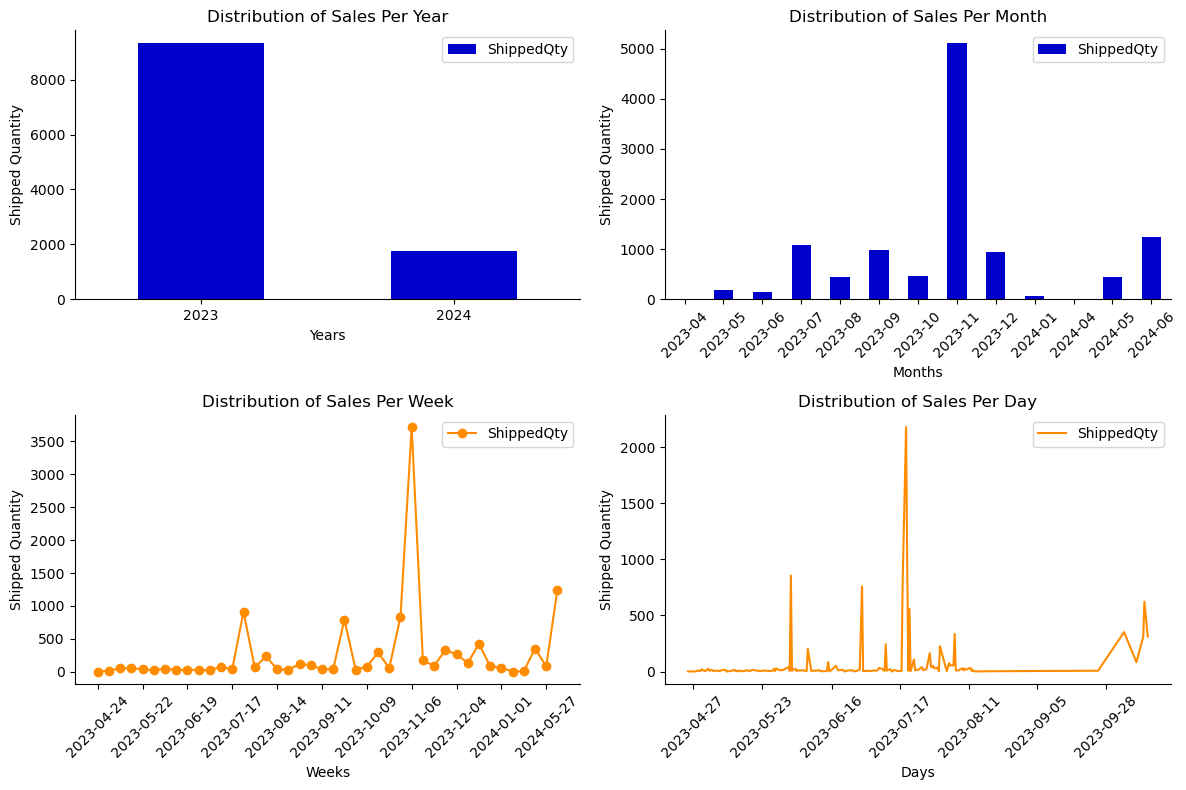

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def sales_aggregation(data, time="monthly"):
    data = data.copy()

    # Convert 'Date' column to datetime format
    data["Date"] = pd.to_datetime(data["Date"])

    # Aggregate based on selected time period
    if time == "monthly":
        data["Date"] = data["Date"].dt.to_period("M").astype(str)
    elif time == "yearly":
        data["Date"] = data["Date"].dt.to_period("Y").astype(str)
    elif time == "weekly":
        data["Date"] = data["Date"].dt.to_period("W").apply(lambda x: x.start_time.strftime('%Y-%m-%d'))
    elif time == "daily":
        data["Date"] = data["Date"].dt.date  # Keeps full date
    else:
        raise ValueError("Invalid time period. Choose from 'daily', 'weekly', 'monthly', or 'yearly'.")

    # Sum shipped quantity per selected time period
    data = data.groupby("Date")["ShippedQty"].sum().reset_index()

    # Convert date column back to datetime format (for correct plotting)
    if time in ["monthly", "yearly"]:
        data["Date"] = pd.to_datetime(data["Date"])

    return data


# Aggregated DataFrames
m_df = sales_aggregation(df, "monthly")
y_df = sales_aggregation(df, "yearly")
w_df = sales_aggregation(df, "weekly")
d_df = sales_aggregation(df, "daily")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Yearly sales (Bar Chart)
y_df.plot(kind="bar", x="Date", y="ShippedQty", color="mediumblue", ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Sales Per Year")
axes[0, 0].set_xlabel("Years")
axes[0, 0].set_ylabel("Shipped Quantity")
axes[0, 0].set_xticklabels(y_df["Date"].dt.year, rotation=0)  # Show only years

# Monthly sales (Bar Chart)
m_df.plot(kind="bar", x="Date", y="ShippedQty", color="mediumblue", ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Sales Per Month")
axes[0, 1].set_xlabel("Months")
axes[0, 1].set_ylabel("Shipped Quantity")
axes[0, 1].set_xticklabels(m_df["Date"].dt.strftime('%Y-%m'), rotation=45)  # Show Year-Month

# Weekly sales (Line Chart)
w_df.plot(marker="o", x="Date", y="ShippedQty", color="darkorange", ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Sales Per Week")
axes[1, 0].set_xlabel("Weeks")
axes[1, 0].set_ylabel("Shipped Quantity")
axes[1, 0].set_xticks(range(0, len(w_df), max(1, len(w_df) // 10)))  # Reduce number of x-ticks
axes[1, 0].set_xticklabels(w_df["Date"][::max(1, len(w_df) // 10)], rotation=45)  # Avoid overlap

# Daily sales (Line Chart)
d_df.plot(x="Date", y="ShippedQty", color="darkorange", ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Sales Per Day")
axes[1, 1].set_xlabel("Days")
axes[1, 1].set_ylabel("Shipped Quantity")
# axes[1, 1].set_xticks(range(0, len(d_df), max(1, len(d_df) // 10)))  # Reduce x-ticks
axes[1, 1].set_xticklabels(d_df["Date"][::max(1, len(d_df) // 10)], rotation=45)

# Formatting
plt.tight_layout()
sns.despine()
plt.show()

In [5]:
d_df

# # Aggregated DataFrames
# m_df = sales_aggregation(df, "monthly")
# y_df = sales_aggregation(df, "yearly")
# w_df = sales_aggregation(df, "weekly")
# d_df = sales_aggregation(df, "daily")

Date  ShippedQty
0    2023-04-27           3
1    2023-04-28           1
2    2023-05-01           2
3    2023-05-02           2
4    2023-05-04           1
..          ...         ...
163  2024-05-17         352
164  2024-05-28          84
165  2024-06-03         312
166  2024-06-04         624
167  2024-06-07         312

[168 rows x 2 columns]

## Missing Values

## Outlier Handling

Number of outliers detected: 27


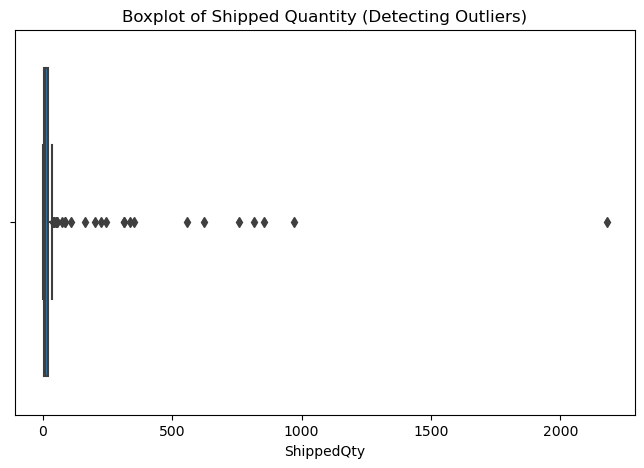

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Compute IQR
Q1 = d_df["ShippedQty"].quantile(0.25)
Q3 = d_df["ShippedQty"].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = d_df[(d_df["ShippedQty"] < lower_bound) | (d_df["ShippedQty"] > upper_bound)]

print(f"Number of outliers detected: {len(outliers)}")

# Visualize with Boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x=d_df["ShippedQty"])
plt.title("Boxplot of Shipped Quantity (Detecting Outliers)")
plt.show()



# Cap extreme values at the upper and lower bounds
d_df["ShippedQty"] = np.where(d_df["ShippedQty"] > upper_bound, upper_bound,
                             np.where(d_df["ShippedQty"] < lower_bound, lower_bound, d_df["ShippedQty"]))

## Transform the Data
Why Transform the Data?
- Fix Skewed Distributions → Many demand datasets are right-skewed due to rare high-sales events.
- Stabilize Variance → Reducing variance improves forecasting model accuracy.
- Improve Normality → Some models (like ARIMA, Linear Regression) perform better with normally distributed data.


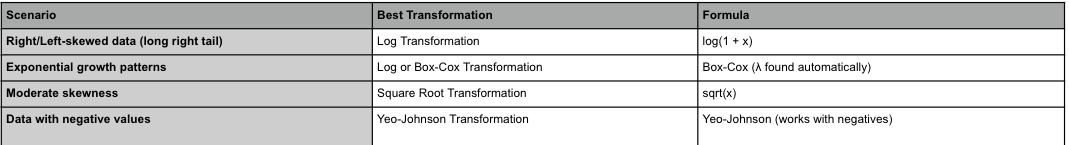


Skewness of ShippedQty: 0.98


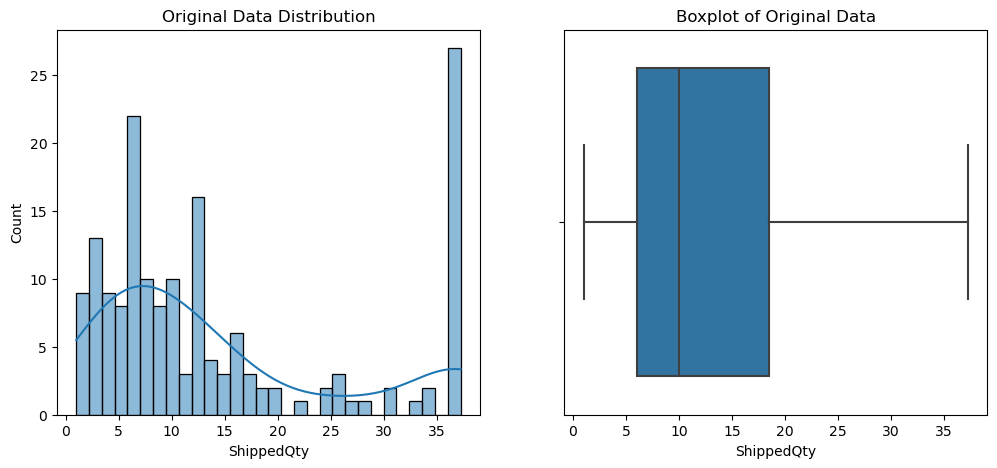

In [7]:
from scipy.stats import skew

# Compute skewness
skewness = d_df["ShippedQty"].skew()
print(f"Skewness of ShippedQty: {skewness:.2f}")

# Visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(d_df["ShippedQty"], bins=30, kde=True)
plt.title("Original Data Distribution")

plt.subplot(1, 2, 2)
sns.boxplot(x=d_df["ShippedQty"])
plt.title("Boxplot of Original Data")

plt.show()

In [8]:
# Log Transformation

# d_df["ShippedQty_Log"] = np.log1p(d_df["ShippedQty"])
d_df["ShippedQty_Sqrt"] = np.sqrt(d_df["ShippedQty"])

## Step 3: Scaling the Data
### Applying Scaling



In [9]:
# X = d_df[["ShippedQty"]].values  
X = d_df[["ShippedQty_Sqrt"]].values

# Apply different scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

d_df["MinMaxScaled"] = minmax_scaler.fit_transform(X)
d_df["StandardScaled"] = standard_scaler.fit_transform(X)
d_df["RobustScaled"] = robust_scaler.fit_transform(X)

# Display first few rows
print(d_df.head())

         Date  ShippedQty  ShippedQty_Sqrt  MinMaxScaled  StandardScaled  \
0  2023-04-27         3.0         1.732051      0.143447       -1.166544   
1  2023-04-28         1.0         1.000000      0.000000       -1.649423   
2  2023-05-01         2.0         1.414214      0.081166       -1.376197   
3  2023-05-02         2.0         1.414214      0.081166       -1.376197   
4  2023-05-04         1.0         1.000000      0.000000       -1.649423   

   RobustScaled  
0     -0.772876  
1     -1.168467  
2     -0.944632  
3     -0.944632  
4     -1.168467  


### Visualizing Scaling Effects

	•	If data has many outliers → Use RobustScaler (preserves spread but reduces extreme values).
	•	If data is normally distributed → Use StandardScaler (best for models requiring normal distribution).
	•	If using deep learning models (LSTMs, RNNs, etc.) → Use MinMaxScaler (suitable for 0-1 range).

In [10]:
# plt.figure(figsize=(15, 5))

# plt.subplot(1, 4, 1)
# plt.hist(d_df["ShippedQty_Sqrt"], bins=30, color="blue", alpha=0.6, label="ShippedQty")
# plt.title("MinMax Scaler")

# plt.subplot(1, 4, 2)
# plt.hist(d_df["MinMaxScaled"], bins=30, color="blue", alpha=0.6, label="MinMax Scaled")
# plt.title("MinMax Scaler")

# plt.subplot(1, 4, 3)
# plt.hist(d_df["StandardScaled"], bins=30, color="green", alpha=0.6, label="Standard Scaled")
# plt.title("Standard Scaler")

# plt.subplot(1, 4, 4)
# plt.hist(d_df["RobustScaled"], bins=30, color="red", alpha=0.6, label="Robust Scaled")
# plt.title("Robust Scaler")

# plt.tight_layout()
# plt.show()

In [11]:
# Compare statistics for each scaling method
scaling_summary = d_df[["ShippedQty_Sqrt", "MinMaxScaled", "StandardScaled", "RobustScaled"]].describe()
scaling_summary

ShippedQty_Sqrt  MinMaxScaled  StandardScaled  RobustScaled
count       168.000000    168.000000    1.680000e+02    168.000000
mean          3.500542      0.489988   -3.172066e-16      0.182794
std           1.520542      0.297954    1.002990e+00      0.821682
min           1.000000      0.000000   -1.649423e+00     -1.168467
25%           2.449490      0.284031   -6.933019e-01     -0.385182
50%           3.162278      0.423704   -2.231283e-01      0.000000
75%           4.300015      0.646646    5.273528e-01      0.614818
max           6.103278      1.000000    1.716833e+00      1.589279

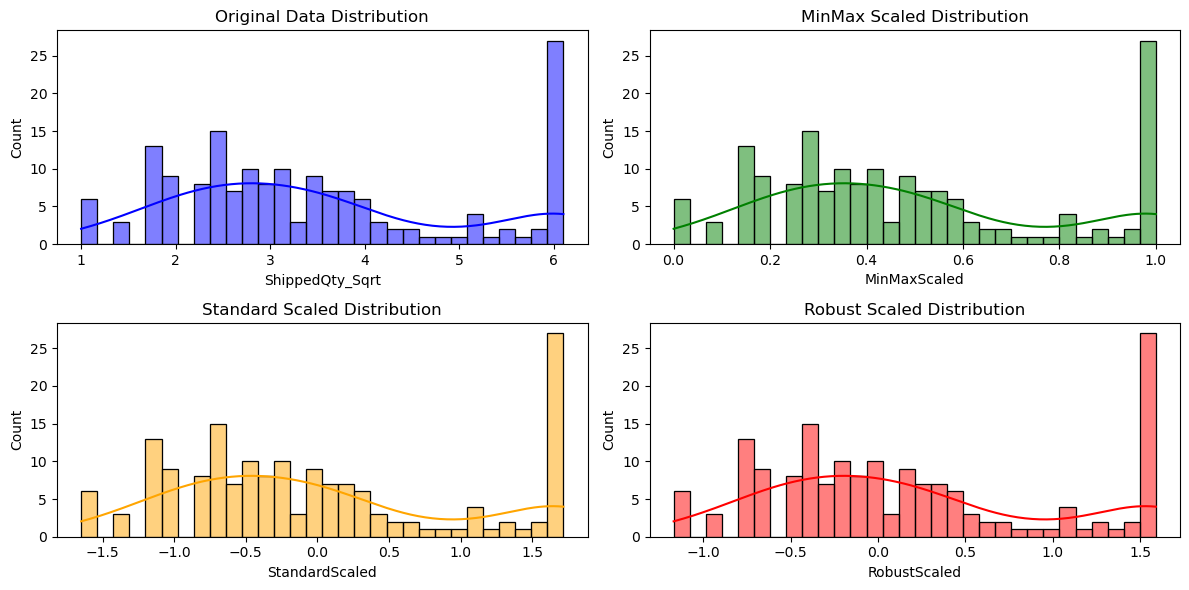

In [13]:
plt.figure(figsize=(12, 6))

# Original Data
plt.subplot(2, 2, 1)
sns.histplot(d_df["ShippedQty_Sqrt"], bins=30, kde=True, color="blue")
plt.title("Original Data Distribution")

# MinMaxScaler
plt.subplot(2, 2, 2)
sns.histplot(d_df["MinMaxScaled"], bins=30, kde=True, color="green")
plt.title("MinMax Scaled Distribution")

# StandardScaler
plt.subplot(2, 2, 3)
sns.histplot(d_df["StandardScaled"], bins=30, kde=True, color="orange")
plt.title("Standard Scaled Distribution")

# RobustScaler
plt.subplot(2, 2, 4)
sns.histplot(d_df["RobustScaled"], bins=30, kde=True, color="red")
plt.title("Robust Scaled Distribution")

plt.tight_layout()
plt.show()

In [14]:
# Compare mean and standard deviation across scaling methods
scaling_summary = d_df[["ShippedQty", "MinMaxScaled", "StandardScaled", "RobustScaled"]].describe()
print(scaling_summary)

# Compare standard deviation before and after scaling
scaling_variance = d_df[["ShippedQty", "MinMaxScaled", "StandardScaled", "RobustScaled"]].std()
scaling_variance

       ShippedQty  MinMaxScaled  StandardScaled  RobustScaled
count  168.000000    168.000000    1.680000e+02    168.000000
mean    14.552083      0.489988   -3.172066e-16      0.182794
std     12.017199      0.297954    1.002990e+00      0.821682
min      1.000000      0.000000   -1.649423e+00     -1.168467
25%      6.000000      0.284031   -6.933019e-01     -0.385182
50%     10.000000      0.423704   -2.231283e-01      0.000000
75%     18.500000      0.646646    5.273528e-01      0.614818
max     37.250000      1.000000    1.716833e+00      1.589279


ShippedQty        12.017199
MinMaxScaled       0.297954
StandardScaled     1.002990
RobustScaled       0.821682
dtype: float64

## Feature Engineeing 

### Feature Engineering for Statistical Models (ARIMA, SARIMA, ARIMAX)

In [17]:
d_df.columns

Index(['Date', 'ShippedQty', 'ShippedQty_Sqrt', 'MinMaxScaled',
       'StandardScaled', 'RobustScaled'],
      dtype='object')

In [18]:
# Prepare d_df for Statistical Models
d_df_stat = d_df.copy()

# Keep only necessary columns for ARIMA/SARIMA (no external variables)
d_df_stat = d_df_stat[["Date", "ShippedQty_Sqrt"]]

# Apply differencing for stationarity (ARIMA requires this)
d_df_stat["ShippedQty_Diff"] = d_df_stat["ShippedQty_Sqrt"].diff()

# Drop NaN values after differencing
d_df_stat = d_df_stat.dropna().reset_index(drop=True)

In [26]:
print(d_df_stat.head())

         Date  ShippedQty_Sqrt  ShippedQty_Diff
0  2023-04-28         1.000000        -0.732051
1  2023-05-01         1.414214         0.414214
2  2023-05-02         1.414214         0.000000
3  2023-05-04         1.000000        -0.414214
4  2023-05-05         3.000000         2.000000


###  Feature Engineering for Machine Learning Models

In [22]:
# Prepare d_df for Machine Learning Models using ShippedQty_Sqrt
d_df_ml = d_df.copy()

# Extract basic date-based features
d_df_ml["Date"] = pd.to_datetime(d_df_ml["Date"])
d_df_ml["DayOfWeek"] = d_df_ml["Date"].dt.dayofweek
d_df_ml["Month"] = d_df_ml["Date"].dt.month

# Add lag features using ShippedQty_Sqrt
d_df_ml["Lag_1"] = d_df_ml["ShippedQty_Sqrt"].shift(1)
d_df_ml["Lag_7"] = d_df_ml["ShippedQty_Sqrt"].shift(7)
d_df_ml["Lag_14"] = d_df_ml["ShippedQty_Sqrt"].shift(14)
d_df_ml["Lag_30"] = d_df_ml["ShippedQty_Sqrt"].shift(30)

# Add rolling statistics using ShippedQty_Sqrt
d_df_ml["Rolling_7"] = d_df_ml["ShippedQty_Sqrt"].rolling(window=7).mean()
d_df_ml["Rolling_7_Std"] = d_df_ml["ShippedQty_Sqrt"].rolling(window=7).std()

# Add cyclical encoding for date-based features
d_df_ml["DayOfWeek_Sin"] = np.sin(2 * np.pi * d_df_ml["DayOfWeek"] / 7)
d_df_ml["DayOfWeek_Cos"] = np.cos(2 * np.pi * d_df_ml["DayOfWeek"] / 7)
d_df_ml["Month_Sin"] = np.sin(2 * np.pi * d_df_ml["Month"] / 12)
d_df_ml["Month_Cos"] = np.cos(2 * np.pi * d_df_ml["Month"] / 12)

# Add feature interactions using ShippedQty_Sqrt
d_df_ml["Lag_1_to_Lag_7_Ratio"] = d_df_ml["Lag_1"] / (d_df_ml["Lag_7"] + 1e-5)
d_df_ml["Lag_7_to_Lag_14_Ratio"] = d_df_ml["Lag_7"] / (d_df_ml["Lag_14"] + 1e-5)

# Drop NaN values after feature engineering
d_df_ml = d_df_ml.dropna().reset_index(drop=True)

In [27]:
print(d_df_ml.head())

        Date  ShippedQty  ShippedQty_Sqrt  MinMaxScaled  StandardScaled  \
0 2023-06-13         4.0         2.000000      0.195952       -0.989797   
1 2023-06-14         3.0         1.732051      0.143447       -1.166544   
2 2023-06-16         7.0         2.645751      0.322489       -0.563843   
3 2023-06-19        13.0         3.605551      0.510564        0.069267   
4 2023-06-20         3.0         1.732051      0.143447       -1.166544   

   RobustScaled  DayOfWeek  Month     Lag_1     Lag_7    Lag_14    Lag_30  \
0     -0.628080          1      6  3.162278  1.732051  2.645751  1.732051   
1     -0.772876          2      6  2.000000  3.000000  2.449490  1.000000   
2     -0.279124          4      6  1.732051  3.741657  2.000000  1.414214   
3      0.239539          0      6  2.645751  3.000000  3.316625  1.414214   
4     -0.772876          1      6  3.605551  3.741657  4.000000  1.000000   

   Rolling_7  Rolling_7_Std  DayOfWeek_Sin  DayOfWeek_Cos     Month_Sin  \
0   2.91109

### Feature Engineering for Neural Networks

In [24]:
# Prepare d_df for Neural Networks
d_df_nn = d_df.copy()

# Convert Date column to datetime
d_df_nn["Date"] = pd.to_datetime(d_df_nn["Date"])

# Extract basic cyclical date-based features
d_df_nn["DayOfWeek"] = d_df_nn["Date"].dt.dayofweek
d_df_nn["Month"] = d_df_nn["Date"].dt.month

# Cyclical encoding for date-based features
d_df_nn["DayOfWeek_Sin"] = np.sin(2 * np.pi * d_df_nn["DayOfWeek"] / 7)
d_df_nn["DayOfWeek_Cos"] = np.cos(2 * np.pi * d_df_nn["DayOfWeek"] / 7)
d_df_nn["Month_Sin"] = np.sin(2 * np.pi * d_df_nn["Month"] / 12)
d_df_nn["Month_Cos"] = np.cos(2 * np.pi * d_df_nn["Month"] / 12)

# Drop unnecessary categorical columns that NN models don't need
d_df_nn = d_df_nn.drop(columns=["DayOfWeek", "Month"])

# Drop NaN values (if any)
d_df_nn = d_df_nn.dropna().reset_index(drop=True)

In [29]:
print(d_df_nn.head())

        Date  ShippedQty  ShippedQty_Sqrt  MinMaxScaled  StandardScaled  \
0 2023-04-27         3.0         1.732051      0.143447       -1.166544   
1 2023-04-28         1.0         1.000000      0.000000       -1.649423   
2 2023-05-01         2.0         1.414214      0.081166       -1.376197   
3 2023-05-02         2.0         1.414214      0.081166       -1.376197   
4 2023-05-04         1.0         1.000000      0.000000       -1.649423   

   RobustScaled  DayOfWeek_Sin  DayOfWeek_Cos  Month_Sin  Month_Cos  
0     -0.772876       0.433884      -0.900969   0.866025  -0.500000  
1     -1.168467      -0.433884      -0.900969   0.866025  -0.500000  
2     -0.944632       0.000000       1.000000   0.500000  -0.866025  
3     -0.944632       0.781831       0.623490   0.500000  -0.866025  
4     -1.168467       0.433884      -0.900969   0.500000  -0.866025  


## Perform Train-Test Split (Chronological Order)

We will split the dataset 80-20, keeping the most recent 20% as the test set.

In [32]:
# Stat
# Define train-test split ratio (80-20)
train_size = int(len(d_df_stat) * 0.8)

# Train-Test Split (Chronological Order)
train_stat, test_stat = d_df_stat.iloc[:train_size], d_df_stat.iloc[train_size:]

print(f"Stat Models -> Train size: {len(train_stat)}, Test size: {len(test_stat)}")

# ML
# Define train-test split ratio (80-20)
train_size = int(len(d_df_ml) * 0.8)

# Train-Test Split (Chronological Order)
X_train_ml, X_test_ml = d_df_ml.iloc[:train_size].drop(columns=["Date", "ShippedQty_Sqrt"]), d_df_ml.iloc[train_size:].drop(columns=["Date", "ShippedQty_Sqrt"])
y_train_ml, y_test_ml = d_df_ml.iloc[:train_size]["ShippedQty_Sqrt"], d_df_ml.iloc[train_size:]["ShippedQty_Sqrt"]

print(f"ML Models -> Train size: {len(X_train_ml)}, Test size: {len(X_test_ml)}")

# NN
# Define train-test split ratio (80-20)
train_size = int(len(d_df_nn) * 0.8)

# Train-Test Split (Chronological Order)
X_train_nn, X_test_nn = d_df_nn.iloc[:train_size].drop(columns=["Date", "ShippedQty_Sqrt"]), d_df_nn.iloc[train_size:].drop(columns=["Date", "ShippedQty_Sqrt"])
y_train_nn, y_test_nn = d_df_nn.iloc[:train_size]["ShippedQty_Sqrt"], d_df_nn.iloc[train_size:]["ShippedQty_Sqrt"]

print(f"NN Models -> Train size: {len(X_train_nn)}, Test size: {len(X_test_nn)}")

Stat Models -> Train size: 133, Test size: 34
ML Models -> Train size: 110, Test size: 28
NN Models -> Train size: 134, Test size: 34


### Visualize Train-Test Split

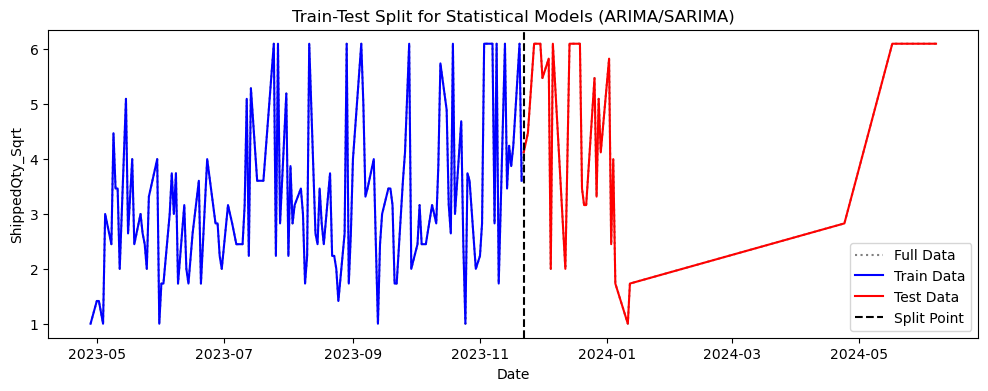

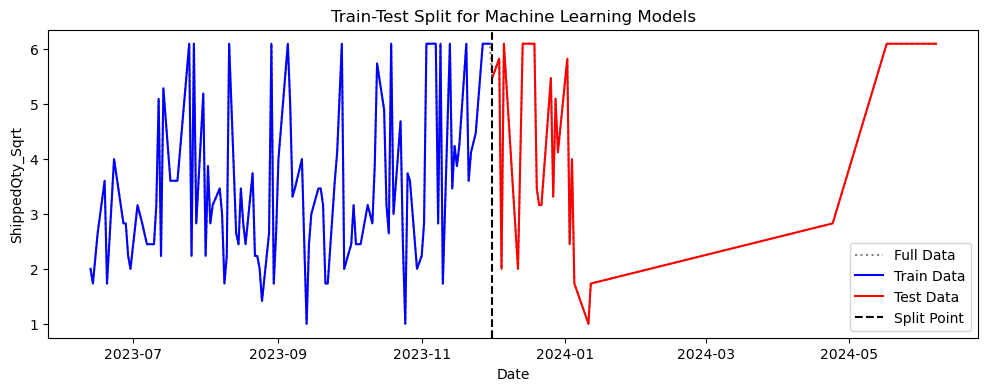

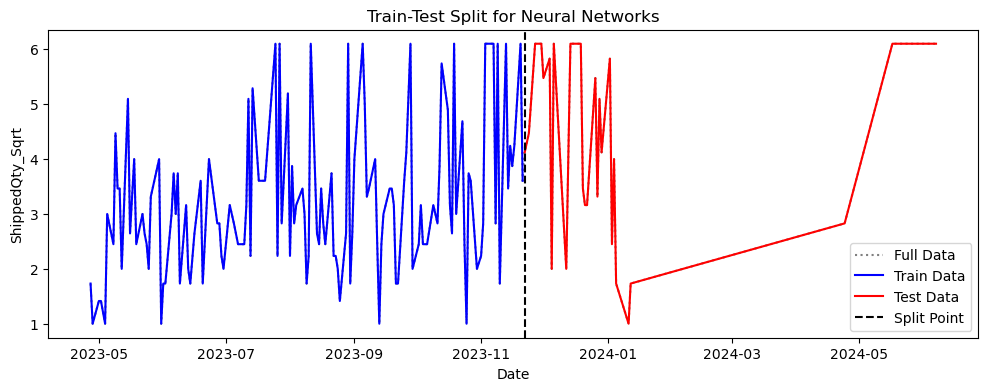

In [38]:
import matplotlib.pyplot as plt

train_size_stat = int(len(d_df_stat) * 0.8)
train_size_ml = int(len(d_df_ml) * 0.8)
train_size_nn = int(len(d_df_nn) * 0.8)


# Step 1: Visualize Train-Test Split for Statistical Models
plt.figure(figsize=(12, 4))
plt.plot(d_df_stat["Date"], d_df_stat["ShippedQty_Sqrt"], label="Full Data", color="gray", linestyle="dotted")
plt.plot(train_stat["Date"], train_stat["ShippedQty_Sqrt"], label="Train Data", color="blue")
plt.plot(test_stat["Date"], test_stat["ShippedQty_Sqrt"], label="Test Data", color="red")
plt.axvline(x=d_df_stat["Date"].iloc[train_size_stat], color="black", linestyle="--", label="Split Point")
plt.legend()
plt.title("Train-Test Split for Statistical Models (ARIMA/SARIMA)")
plt.xlabel("Date")
plt.ylabel("ShippedQty_Sqrt")
plt.show()

# Step 2: Visualize Train-Test Split for Machine Learning Models
plt.figure(figsize=(12, 4))
plt.plot(d_df_ml["Date"], d_df_ml["ShippedQty_Sqrt"], label="Full Data", color="gray", linestyle="dotted")
plt.plot(d_df_ml["Date"].iloc[:train_size_ml], y_train_ml, label="Train Data", color="blue")
plt.plot(d_df_ml["Date"].iloc[train_size_ml:], y_test_ml, label="Test Data", color="red")
plt.axvline(x=d_df_ml["Date"].iloc[train_size_ml], color="black", linestyle="--", label="Split Point")
plt.legend()
plt.title("Train-Test Split for Machine Learning Models")
plt.xlabel("Date")
plt.ylabel("ShippedQty_Sqrt")
plt.show()

# Step 3: Visualize Train-Test Split for Neural Networks
plt.figure(figsize=(12, 4))
plt.plot(d_df_nn["Date"], d_df_nn["ShippedQty_Sqrt"], label="Full Data", color="gray", linestyle="dotted")
plt.plot(d_df_nn["Date"].iloc[:train_size_nn], y_train_nn, label="Train Data", color="blue")
plt.plot(d_df_nn["Date"].iloc[train_size_nn:], y_test_nn, label="Test Data", color="red")
plt.axvline(x=d_df_nn["Date"].iloc[train_size_nn], color="black", linestyle="--", label="Split Point")
plt.legend()
plt.title("Train-Test Split for Neural Networks")
plt.xlabel("Date")
plt.ylabel("ShippedQty_Sqrt")
plt.show()

## Traditional Statistical Models (ARIMA, SARIMA, Exponential Smoothing)

* ARIMA (Auto-Regressive Integrated Moving Average) → Best for non-seasonal data.
* SARIMA (Seasonal ARIMA) → Captures seasonality in demand.
* Exponential Smoothing (Simple, Holt-Winters Method) → Captures trends and seasonal variations.
### ARIMA Model

#### Check Data Stationarity (Required for ARIMA)
* p-value < 0.05 → Data is stationary → ARIMA is ready to use.
* p-value ≥ 0.05 → Data is non-stationary → We must apply differencing.

#### How to Interpret PACF for ARIMA?
* If PACF cuts off sharply after a few lags (e.g., lag 1 or 2) → Use p = number of significant lags in ARIMA(p, d, q).
* If PACF gradually declines → The process might require a higher p value or differencing (d).
* If PACF has significant lags at seasonal intervals (e.g., 7, 30, etc.) → Suggests using SARIMA.

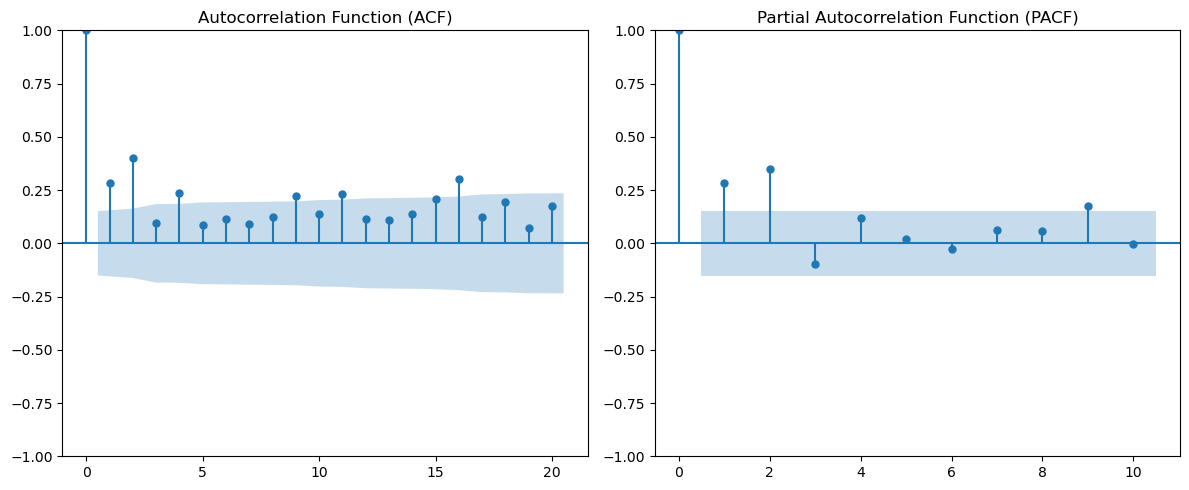

ADF Statistic: -6.1477
p-value: 0.0000
Critical Values:
	1%: -3.4813
	5%: -2.8839
	10%: -2.5787

✅ Data is already stationary (p < 0.05). Proceeding with ARIMA.
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75471D+00    |proj g|=  1.36884D-01



 This problem is unconstrained.


At iterate    5    f=  1.63221D+00    |proj g|=  2.73352D-02

At iterate   10    f=  1.62633D+00    |proj g|=  3.68418D-03

At iterate   15    f=  1.62603D+00    |proj g|=  4.33333D-04

At iterate   20    f=  1.62603D+00    |proj g|=  4.91522D-05

At iterate   25    f=  1.62597D+00    |proj g|=  3.52123D-04

At iterate   30    f=  1.62596D+00    |proj g|=  2.39014D-04

At iterate   35    f=  1.62595D+00    |proj g|=  5.30223D-05

At iterate   40    f=  1.62595D+00    |proj g|=  3.48296D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     51      1     0     0   3.483D-04   1.626D+00
  F =   1.625952501686

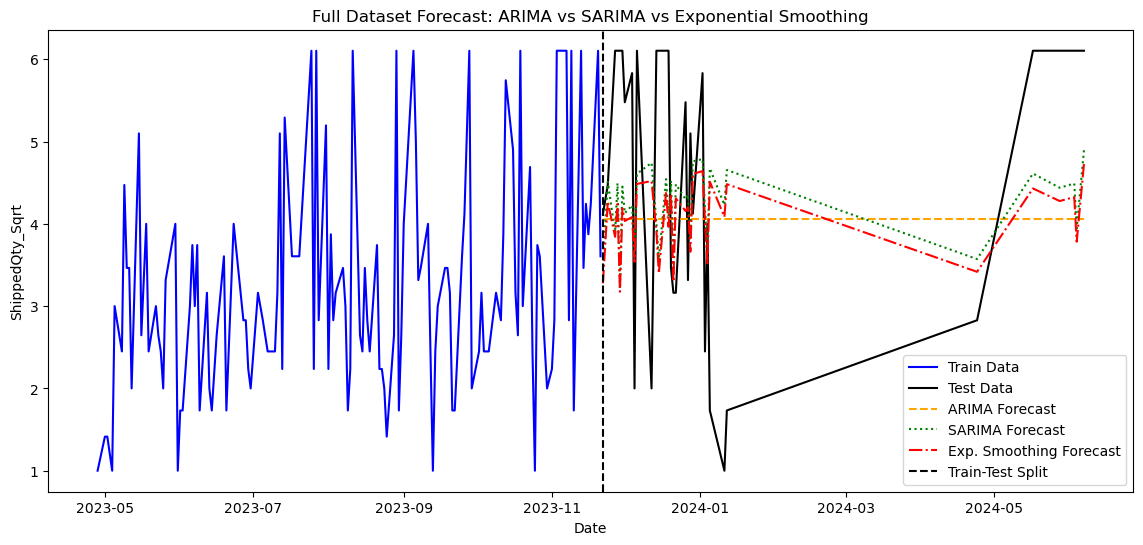

In [54]:
# Import necessary libraries
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: ACF & PACF Plots (Identifies p and q for ARIMA)
def plot_acf_pacf(data, column):
    # Drop NaN values if present
    clean_data = data[column].dropna()
    
    # Set figure size
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # ACF Plot (Identifies q)
    plot_acf(clean_data, lags=20, alpha=0.05, ax=axes[0])
    axes[0].set_title("Autocorrelation Function (ACF)")

    # PACF Plot (Identifies p)
    plot_pacf(clean_data, lags=10, method="ywm", alpha=0.05, ax=axes[1])
    axes[1].set_title("Partial Autocorrelation Function (PACF)")

    plt.tight_layout()
    plt.show()

plot_acf_pacf(d_df, "ShippedQty")

# Step 2: Check Data Stationarity (ADF Test)
def check_stationarity(data, column):
    adf_test = adfuller(data[column])
    print(f"ADF Statistic: {adf_test[0]:.4f}")
    print(f"p-value: {adf_test[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_test[4].items():
        print(f"\t{key}: {value:.4f}")

    return adf_test[1]  # Return p-value

# Step 3: Apply Differencing if Needed
def apply_differencing(data, column):
    p_value = check_stationarity(data, column)
    
    if p_value >= 0.05:
        print("\n❌ Data is non-stationary (p >= 0.05). Applying first-order differencing...")
        data["ShippedQty_Sqrt_Diff"] = data[column].diff().dropna()

        # Re-run stationarity test
        new_p_value = check_stationarity(data.dropna(), "ShippedQty_Sqrt_Diff")

        if new_p_value < 0.05:
            print("✅ Data is now stationary after differencing.")
        else:
            print("⚠ Data may still be non-stationary. Consider additional transformations.")
    else:
        print("\n✅ Data is already stationary (p < 0.05). Proceeding with ARIMA.")

apply_differencing(train_stat, "ShippedQty_Sqrt")

# Step 4: Fit ARIMA Model
def fit_arima(train_data, test_data):
    p, d, q = 1, 1, 1  # Adjust based on ACF/PACF analysis
    target_col = "ShippedQty_Sqrt_Diff" if "ShippedQty_Sqrt_Diff" in train_data.columns else "ShippedQty_Sqrt"

    arima_model = ARIMA(train_data[target_col], order=(p, d, q))
    arima_fit = arima_model.fit()
    test_data.loc[:, "ARIMA_Forecast"] = arima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
    return test_data

test_stat = fit_arima(train_stat, test_stat)

# Step 5: Fit SARIMA Model
def fit_sarima(train_data, test_data):
    p, d, q = 1, 1, 1  # Non-seasonal terms
    P, D, Q, S = 1, 1, 1, 12  # Seasonal terms (Assuming monthly seasonality)

    sarima_model = SARIMAX(
        train_data["ShippedQty_Sqrt"],
        order=(p, d, q),
        seasonal_order=(P, D, Q, S)
    )
    sarima_fit = sarima_model.fit()
    test_data.loc[:, "SARIMA_Forecast"] = sarima_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)
    return test_data

test_stat = fit_sarima(train_stat, test_stat)

# Step 6: Fit Exponential Smoothing Model
def fit_exponential_smoothing(train_data, test_data):
    hw_model = ExponentialSmoothing(train_data["ShippedQty_Sqrt"], trend="add", seasonal="add", seasonal_periods=12)
    hw_fit = hw_model.fit()
    test_data.loc[:, "ExpSmooth_Forecast"] = hw_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    return test_data

test_stat = fit_exponential_smoothing(train_stat, test_stat)

# Step 7: Visualize Model Performance Over Entire Dataset
def plot_full_forecast(train_data, test_data):
    plt.figure(figsize=(14, 6))

    # Plot actual data (train + test)
    plt.plot(train_data["Date"], train_data["ShippedQty_Sqrt"], label="Train Data", color="blue")
    plt.plot(test_data["Date"], test_data["ShippedQty_Sqrt"], label="Test Data", color="black")

    # Plot model forecasts
    plt.plot(test_data["Date"], test_data["ARIMA_Forecast"], label="ARIMA Forecast", linestyle="dashed", color="orange")
    plt.plot(test_data["Date"], test_data["SARIMA_Forecast"], label="SARIMA Forecast", linestyle="dotted", color="green")
    plt.plot(test_data["Date"], test_data["ExpSmooth_Forecast"], label="Exp. Smoothing Forecast", linestyle="dashdot", color="red")

    # Add split line between train and test
    plt.axvline(x=test_data["Date"].iloc[0], color="black", linestyle="--", label="Train-Test Split")

    plt.legend()
    plt.title("Full Dataset Forecast: ARIMA vs SARIMA vs Exponential Smoothing")
    plt.xlabel("Date")
    plt.ylabel("ShippedQty_Sqrt")
    plt.show()

# Visualize entire dataset performance
plot_full_forecast(train_stat, test_stat)